In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from utilities.helper_functions import plot_decision_boundary

torch.__version__

'2.7.1+cu118'

## Agnostic device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Create data

[[-7.14824467 -5.25849305]
 [-9.29912919  5.47505663]
 [-7.83859951  4.52491057]
 [ 5.99573058  0.99734687]
 [ 8.76288599  4.38990215]] [2 3 3 1 1]


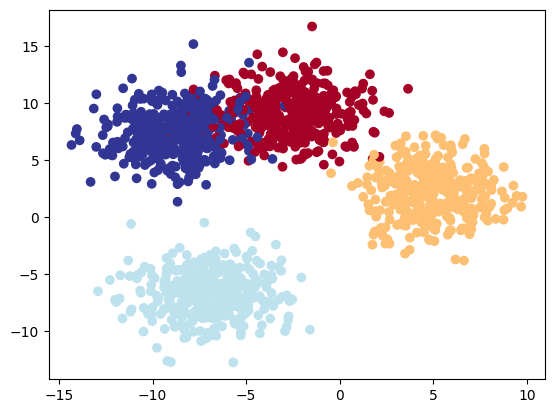

In [3]:
 # set hyperparameters for data creation

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# create multi-class data

X_blob, y_blob = make_blobs(
    n_samples=1500,
    centers=NUM_CLASSES,
    n_features=NUM_FEATURES,
    cluster_std=2,
    random_state=RANDOM_SEED
)

print(X_blob[:5], y_blob[:5])

# split train and test

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    train_size=0.8,
    random_state=RANDOM_SEED
)

# plot data

plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

## Put data on CUDA

In [4]:

X_blob_train = torch.from_numpy(X_blob_train).type(torch.float32).to(device)
X_blob_test = torch.from_numpy(X_blob_test).type(torch.float32).to(device)
y_blob_train = torch.from_numpy(y_blob_train).type(torch.LongTensor).to(device)
y_blob_test = torch.from_numpy(y_blob_test).type(torch.LongTensor).to(device)
X_blob_train.device, X_blob_test.device, y_blob_train.device, y_blob_test.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [5]:
def put_data_on_cpu():

    global X_blob_train, X_blob_test, y_blob_train, y_blob_test
    X_blob_train = X_blob_train.cpu()
    X_blob_test = X_blob_test.cpu()
    y_blob_train = y_blob_train.cpu()
    y_blob_test = y_blob_test.cpu()

In [6]:
def put_data_on_gpu():

    global X_blob_train, X_blob_test, y_blob_train, y_blob_test
    X_blob_train = X_blob_train.to(device)
    X_blob_test = X_blob_test.to(device)
    y_blob_train = y_blob_train.to(device)
    y_blob_test = y_blob_test.to(device)

In [7]:
put_data_on_cpu()
X_blob_train.device

device(type='cpu')

In [8]:
put_data_on_gpu()
X_blob_train.device

device(type='cuda', index=0)

In [9]:
X_blob_train, y_blob_train

(tensor([[ 9.2785,  2.7598],
         [ 7.1514,  0.1840],
         [-6.6924, 12.0513],
         ...,
         [ 1.9510,  0.1359],
         [-6.0987, -7.0866],
         [-6.0027, -6.8409]], device='cuda:0'),
 tensor([1, 1, 3,  ..., 1, 2, 2], device='cuda:0'))

## Create model for multi-calss classification

In [10]:
class MultiClassClassificationV0(nn.Module):

    def __init__(self, input_feature, output_feature, hidden_units):
        super().__init__()

        self.linear_layer_stack = nn.Sequential(

            nn.Linear(in_features=input_feature, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_feature)
        )

        # self.layer1 = nn.Linear(in_features=2, out_features=10)
        # self.layer2 = nn.Linear(in_features=10, out_features=10)
        # self.layer3 = nn.Linear(in_features=10, out_features=4)
        # self.relu = nn.ReLU()

    def forward(self, x: torch.tensor) -> torch.tensor:

        # return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
        return self.linear_layer_stack(x)
    
model_0 = MultiClassClassificationV0(
                                    input_feature=NUM_FEATURES,
                                    output_feature=NUM_CLASSES,
                                    hidden_units=10
).to(device)
model_0

MultiClassClassificationV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

## Put model on CUDA

In [11]:
# model_0.to(device)
# next(model_0.parameters()).device

## Create loss function and optimizer

In [12]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

## Testing model

In [13]:
model_0(X_blob_train)[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [14]:
logits = model_0(X_blob_train)[:5]
preds = torch.softmax(logits, dim=1)
logits, preds

(tensor([[-0.1520,  0.3909,  0.4086, -0.2905],
         [-0.2833,  0.4126,  0.4185, -0.3660],
         [ 0.6077,  0.0504, -0.3554, -0.0844],
         [-0.2171,  0.3245,  0.2524, -0.3480],
         [ 0.5115,  0.0015, -0.3306, -0.1274]], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor([[0.1872, 0.3221, 0.3278, 0.1629],
         [0.1683, 0.3374, 0.3394, 0.1549],
         [0.4073, 0.2333, 0.1555, 0.2039],
         [0.1925, 0.3308, 0.3078, 0.1689],
         [0.3907, 0.2346, 0.1683, 0.2063]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>))

In [15]:
# lets check which class has the highest value using argmax()

torch.sum(preds[0]), torch.argmax(preds[0]), preds[0]

(tensor(1., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(2, device='cuda:0'),
 tensor([0.1872, 0.3221, 0.3278, 0.1629], device='cuda:0',
        grad_fn=<SelectBackward0>))

### Accuracy

In [16]:
def accuracy_fn(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()
    acc =  (correct / len(y_pred)) * 100
    return acc

In [17]:
train_logits = model_0(X_blob_train)
train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)
# train_loss = loss_fn(train_logits, y_blob_train)
# train_accuracy = accuracy_fn(y_blob_train, train_preds)

train_logits, y_blob_train[0]

(tensor([[-0.1520,  0.3909,  0.4086, -0.2905],
         [-0.2833,  0.4126,  0.4185, -0.3660],
         [ 0.6077,  0.0504, -0.3554, -0.0844],
         ...,
         [-0.0342, -0.0501, -0.0880, -0.3070],
         [ 0.4453, -0.4334, -0.2438, -0.6705],
         [ 0.4393, -0.4241, -0.2423, -0.6520]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor(1, device='cuda:0'))

## Let's create the traning and tesing loop

In [18]:
def fit_fn(epochs):

    for epoch in range(epochs):

        model_0.train()

        train_logits = model_0(X_blob_train)
        train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)
        train_loss = loss_fn(train_logits, y_blob_train)
        train_accuracy = accuracy_fn(y_blob_train, train_preds)

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        ## Testing

        model_0.eval()

        with torch.inference_mode():

            test_logits = model_0(X_blob_test)
            test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_loss = loss_fn(test_logits, y_blob_test)
            test_accuracy = accuracy_fn(y_blob_test, test_preds)

            if epoch % 10 == 0:

                print(f"Epoch: {epoch} --- | Train Loss: {train_loss: .5f} --- | Train Accuracy: {train_accuracy: .2f}% --- | Test Loss: {test_loss: .5f} --- | Test Accuracy: {test_accuracy: .2f}%")

In [19]:
model_0.to(device)
fit_fn(200)

Epoch: 0 --- | Train Loss:  1.33998 --- | Train Accuracy:  35.50% --- | Test Loss:  1.32349 --- | Test Accuracy:  39.00%
Epoch: 10 --- | Train Loss:  1.22560 --- | Train Accuracy:  42.33% --- | Test Loss:  1.21197 --- | Test Accuracy:  42.33%
Epoch: 20 --- | Train Loss:  1.13759 --- | Train Accuracy:  50.75% --- | Test Loss:  1.12628 --- | Test Accuracy:  53.00%
Epoch: 30 --- | Train Loss:  1.05137 --- | Train Accuracy:  68.58% --- | Test Loss:  1.04005 --- | Test Accuracy:  70.00%
Epoch: 40 --- | Train Loss:  0.96334 --- | Train Accuracy:  74.75% --- | Test Loss:  0.95078 --- | Test Accuracy:  78.33%
Epoch: 50 --- | Train Loss:  0.87364 --- | Train Accuracy:  87.50% --- | Test Loss:  0.85871 --- | Test Accuracy:  90.67%
Epoch: 60 --- | Train Loss:  0.78305 --- | Train Accuracy:  91.42% --- | Test Loss:  0.76495 --- | Test Accuracy:  92.67%
Epoch: 70 --- | Train Loss:  0.69349 --- | Train Accuracy:  93.17% --- | Test Loss:  0.67213 --- | Test Accuracy:  94.33%
Epoch: 80 --- | Train Los

## Evalutate model on test data

In [20]:
model_0.eval()

with torch.inference_mode():

    test_logits = model_0(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

test_preds == y_blob_test, accuracy_fn(y_blob_test, test_preds)

(tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False,  True,  True,  True,  True,  True,  True,  True,  True, False,
          True,  True,  True,  True,  True,  True,  True,  True, False,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True, False,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  

## Plot predictions

#### Convert data to cpu for plot

In [21]:
X_blob_train.device

device(type='cuda', index=0)

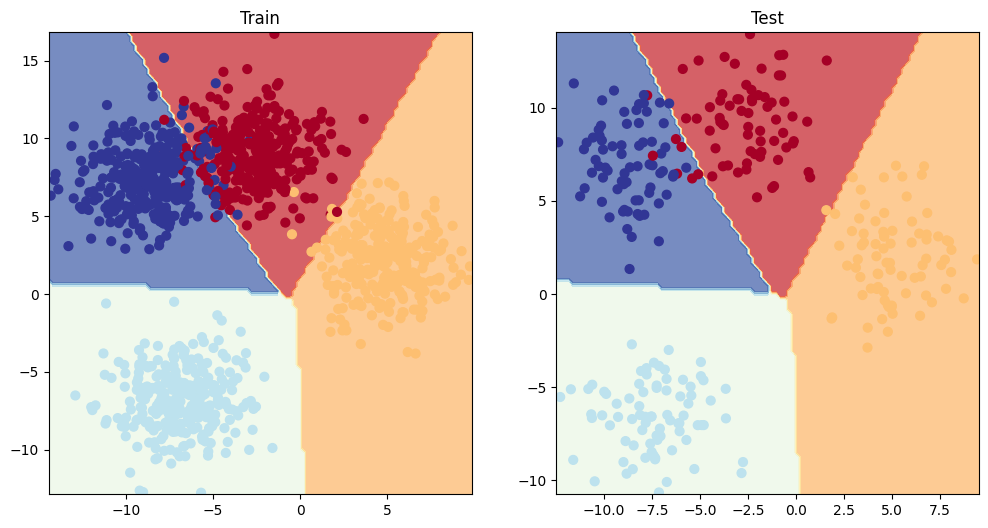

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_blob_test, y_blob_test)